In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch import nn, optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import pandas as pd
import numpy as np

import random

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(4, 10),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded)
        
        return encoded, decoded, classified

In [3]:
class Classifier(nn.Module):
    def __init__(self, encoder):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(4, 10),
#             nn.ReLU(),
#             nn.Linear(128, 32),
#             nn.ReLU(),
#             nn.Linear(32, 10),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        result = self.classifier(encoded)
        return result

In [4]:
EPOCH = 20
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

trainset = datasets.MNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

testset = datasets.MNIST(
    root = './.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

Using Device: cuda


In [5]:
autoencoder = Autoencoder().to(DEVICE)
ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=0.0000001)
ae_criterion = nn.MSELoss()
classify_criterion = nn.CrossEntropyLoss()
loss_history= []
val_loss_history = []
loss_last_history=[]
view_data = trainset.data[10:20].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255

In [6]:
# classifier = Classifier(encoder).to(DEVICE)
# classify_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
# classify_criterion = nn.CrossEntropyLoss()

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    size = len(train_loader.dataset)
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
#         mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
#         x  = (x-mean)/std
        
        encoded, decoded, classified = autoencoder(x)
        
        loss = ae_criterion(decoded, y) + classify_criterion(classified, label)
        
        if step == 1:
            loss_history.append(loss.data)
        
        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()
        
        if step % 100 == 0:
            loss, current = loss.item(), step * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(classifier, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for step, (x, label) in enumerate(test_loader):
            x = x.view(-1, 28*28).to(DEVICE)
            label = label.to(DEVICE)
            
            mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
            x  = (x-mean)/std
            
            _, _, result = autoencoder(x)
#             loss = classify_criterion(result, label)
            test_loss += loss_fn(result, label).item()
            correct += (result.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [9]:
# for epoch in range(1, EPOCH+1):
#     print(epoch)
#     classify_train(classifier, train_loader, classify_criterion)
#     classify_test(classifier, test_loader, classify_criterion)

1 / 20
loss: 2.547575  [    0/60000]
loss: 1.364109  [ 6400/60000]
loss: 0.862509  [12800/60000]
loss: 0.525195  [19200/60000]
loss: 0.356838  [25600/60000]
loss: 0.525560  [32000/60000]
loss: 0.239364  [38400/60000]
loss: 0.337440  [44800/60000]
loss: 0.346162  [51200/60000]
loss: 0.423913  [57600/60000]
Test Error: 
 Accuracy: 58.2%, Avg loss: 6.101480 

[Epoch 1]


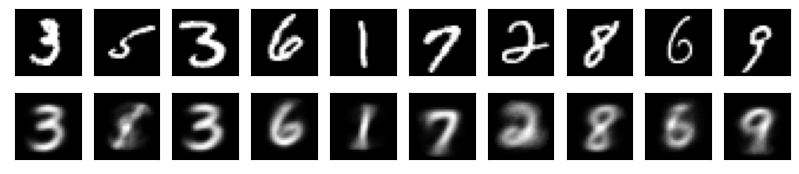

2 / 20
loss: 0.264467  [    0/60000]
loss: 0.235958  [ 6400/60000]
loss: 0.374513  [12800/60000]
loss: 0.271650  [19200/60000]
loss: 0.265969  [25600/60000]
loss: 0.246705  [32000/60000]
loss: 0.308850  [38400/60000]
loss: 0.500124  [44800/60000]
loss: 0.388433  [51200/60000]
loss: 0.111149  [57600/60000]
Test Error: 
 Accuracy: 51.2%, Avg loss: 8.623629 

[Epoch 2]


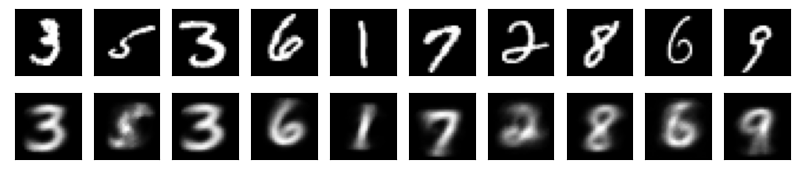

3 / 20
loss: 0.376466  [    0/60000]
loss: 0.253219  [ 6400/60000]
loss: 0.090572  [12800/60000]
loss: 0.104691  [19200/60000]
loss: 0.242430  [25600/60000]
loss: 0.362950  [32000/60000]
loss: 0.373997  [38400/60000]
loss: 0.194977  [44800/60000]
loss: 0.177432  [51200/60000]
loss: 0.205518  [57600/60000]
Test Error: 
 Accuracy: 59.5%, Avg loss: 6.858436 

[Epoch 3]


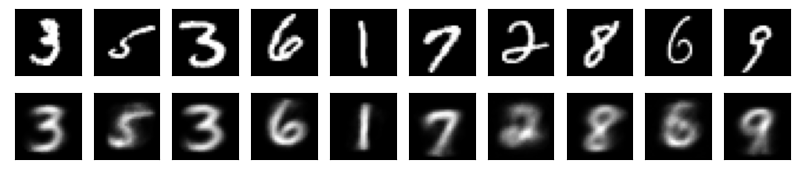

4 / 20
loss: 0.220874  [    0/60000]
loss: 0.305721  [ 6400/60000]
loss: 0.095303  [12800/60000]
loss: 0.215162  [19200/60000]
loss: 0.174707  [25600/60000]
loss: 0.262691  [32000/60000]
loss: 0.079590  [38400/60000]
loss: 0.218790  [44800/60000]
loss: 0.196734  [51200/60000]
loss: 0.145660  [57600/60000]
Test Error: 
 Accuracy: 62.0%, Avg loss: 6.798159 

[Epoch 4]


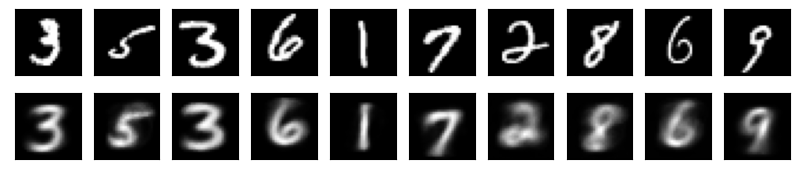

5 / 20
loss: 0.144170  [    0/60000]
loss: 0.217165  [ 6400/60000]
loss: 0.098860  [12800/60000]
loss: 0.162770  [19200/60000]
loss: 0.070571  [25600/60000]
loss: 0.086012  [32000/60000]
loss: 0.096280  [38400/60000]
loss: 0.154324  [44800/60000]
loss: 0.090825  [51200/60000]
loss: 0.242673  [57600/60000]
Test Error: 
 Accuracy: 71.0%, Avg loss: 5.368726 

[Epoch 5]


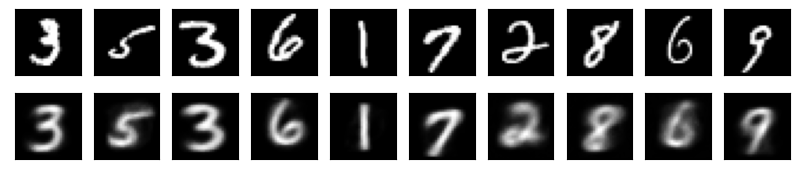

6 / 20
loss: 0.067733  [    0/60000]
loss: 0.080375  [ 6400/60000]
loss: 0.142806  [12800/60000]
loss: 0.105015  [19200/60000]
loss: 0.097210  [25600/60000]
loss: 0.095697  [32000/60000]
loss: 0.119256  [38400/60000]
loss: 0.279330  [44800/60000]
loss: 0.242957  [51200/60000]
loss: 0.127667  [57600/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 4.071985 

[Epoch 6]


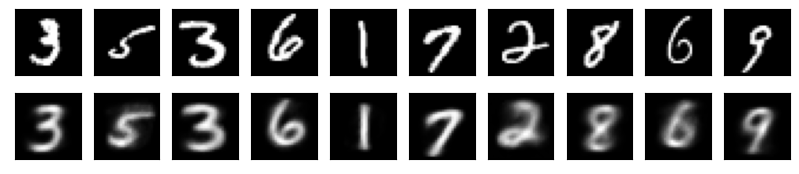

7 / 20
loss: 0.063613  [    0/60000]
loss: 0.088007  [ 6400/60000]
loss: 0.088780  [12800/60000]
loss: 0.065191  [19200/60000]
loss: 0.089640  [25600/60000]
loss: 0.129736  [32000/60000]
loss: 0.285144  [38400/60000]
loss: 0.159008  [44800/60000]
loss: 0.161005  [51200/60000]
loss: 0.122295  [57600/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 3.966569 

[Epoch 7]


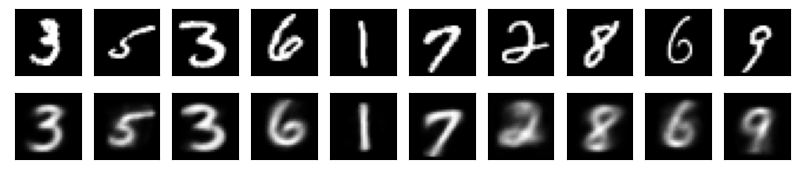

8 / 20
loss: 0.082706  [    0/60000]
loss: 0.055974  [ 6400/60000]
loss: 0.083158  [12800/60000]
loss: 0.080810  [19200/60000]
loss: 0.121364  [25600/60000]
loss: 0.060768  [32000/60000]
loss: 0.049253  [38400/60000]
loss: 0.189082  [44800/60000]
loss: 0.054848  [51200/60000]
loss: 0.051924  [57600/60000]
Test Error: 
 Accuracy: 75.3%, Avg loss: 5.718907 

[Epoch 8]


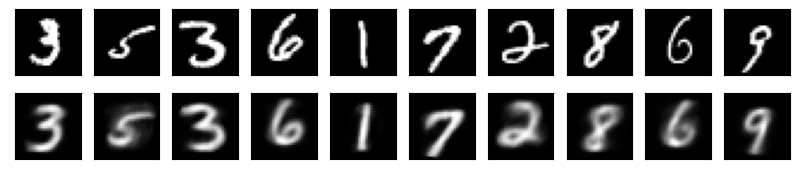

9 / 20
loss: 0.068334  [    0/60000]
loss: 0.050011  [ 6400/60000]
loss: 0.130896  [12800/60000]
loss: 0.085743  [19200/60000]
loss: 0.100147  [25600/60000]
loss: 0.083437  [32000/60000]
loss: 0.050020  [38400/60000]
loss: 0.052827  [44800/60000]
loss: 0.046932  [51200/60000]
loss: 0.081371  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 4.716763 

[Epoch 9]


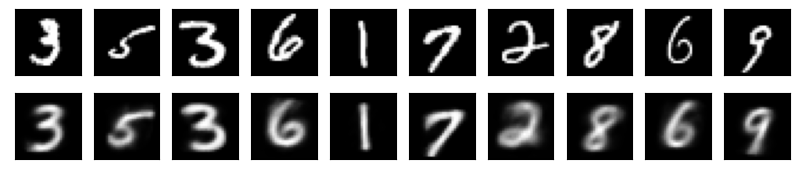

10 / 20
loss: 0.047180  [    0/60000]
loss: 0.044769  [ 6400/60000]
loss: 0.067419  [12800/60000]
loss: 0.086442  [19200/60000]
loss: 0.083509  [25600/60000]
loss: 0.043897  [32000/60000]
loss: 0.122670  [38400/60000]
loss: 0.041042  [44800/60000]
loss: 0.136012  [51200/60000]
loss: 0.143801  [57600/60000]
Test Error: 
 Accuracy: 77.4%, Avg loss: 5.677113 

[Epoch 10]


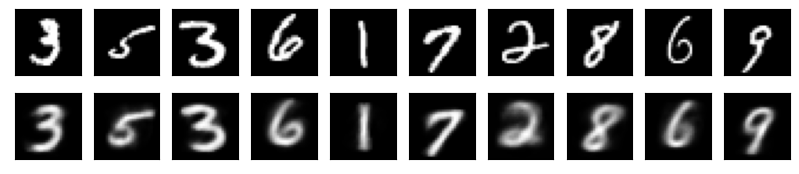

11 / 20
loss: 0.053064  [    0/60000]
loss: 0.050936  [ 6400/60000]
loss: 0.153645  [12800/60000]
loss: 0.046841  [19200/60000]
loss: 0.055162  [25600/60000]
loss: 0.090934  [32000/60000]
loss: 0.053960  [38400/60000]
loss: 0.147826  [44800/60000]
loss: 0.125508  [51200/60000]
loss: 0.049084  [57600/60000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 5.638744 

[Epoch 11]


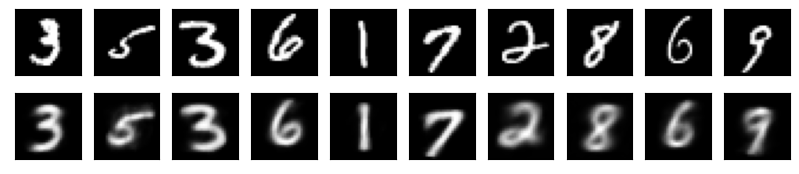

12 / 20
loss: 0.076505  [    0/60000]
loss: 0.071172  [ 6400/60000]
loss: 0.070374  [12800/60000]
loss: 0.041673  [19200/60000]
loss: 0.090768  [25600/60000]
loss: 0.043881  [32000/60000]
loss: 0.084642  [38400/60000]
loss: 0.050362  [44800/60000]
loss: 0.037719  [51200/60000]
loss: 0.070380  [57600/60000]
Test Error: 
 Accuracy: 72.7%, Avg loss: 8.446986 

[Epoch 12]


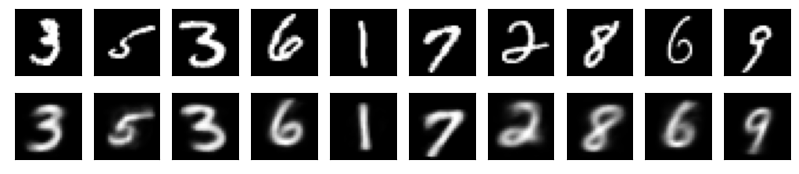

13 / 20
loss: 0.056027  [    0/60000]
loss: 0.082919  [ 6400/60000]
loss: 0.039258  [12800/60000]
loss: 0.048515  [19200/60000]
loss: 0.065765  [25600/60000]
loss: 0.068025  [32000/60000]
loss: 0.041858  [38400/60000]
loss: 0.043880  [44800/60000]
loss: 0.127374  [51200/60000]
loss: 0.199023  [57600/60000]
Test Error: 
 Accuracy: 72.3%, Avg loss: 10.239919 

[Epoch 13]


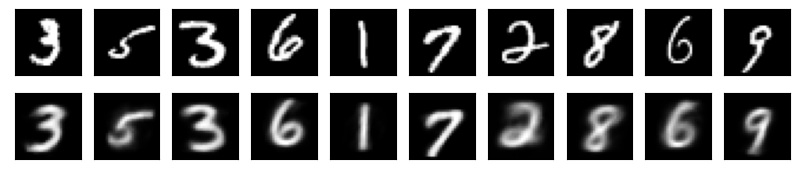

14 / 20
loss: 0.039849  [    0/60000]
loss: 0.043959  [ 6400/60000]
loss: 0.042264  [12800/60000]
loss: 0.041898  [19200/60000]
loss: 0.046266  [25600/60000]
loss: 0.038720  [32000/60000]
loss: 0.043675  [38400/60000]
loss: 0.065751  [44800/60000]
loss: 0.102090  [51200/60000]
loss: 0.040333  [57600/60000]
Test Error: 
 Accuracy: 70.8%, Avg loss: 11.701017 

[Epoch 14]


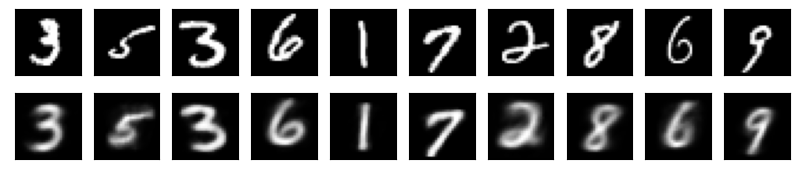

15 / 20
loss: 0.112143  [    0/60000]
loss: 0.050282  [ 6400/60000]
loss: 0.058645  [12800/60000]
loss: 0.042051  [19200/60000]
loss: 0.040655  [25600/60000]
loss: 0.038885  [32000/60000]
loss: 0.062458  [38400/60000]
loss: 0.046920  [44800/60000]
loss: 0.062089  [51200/60000]
loss: 0.037340  [57600/60000]
Test Error: 
 Accuracy: 73.7%, Avg loss: 9.645966 

[Epoch 15]


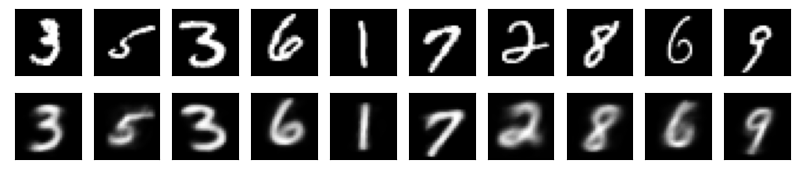

16 / 20
loss: 0.044333  [    0/60000]
loss: 0.034637  [ 6400/60000]
loss: 0.037393  [12800/60000]
loss: 0.069849  [19200/60000]
loss: 0.074445  [25600/60000]
loss: 0.199485  [32000/60000]
loss: 0.051887  [38400/60000]
loss: 0.054824  [44800/60000]
loss: 0.050920  [51200/60000]
loss: 0.053914  [57600/60000]
Test Error: 
 Accuracy: 74.5%, Avg loss: 10.359372 

[Epoch 16]


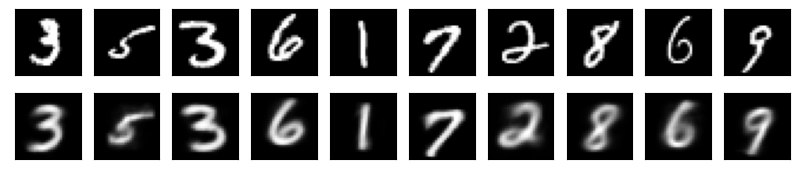

17 / 20
loss: 0.042521  [    0/60000]
loss: 0.040502  [ 6400/60000]
loss: 0.038620  [12800/60000]
loss: 0.042346  [19200/60000]
loss: 0.035210  [25600/60000]
loss: 0.053009  [32000/60000]
loss: 0.041520  [38400/60000]
loss: 0.040121  [44800/60000]
loss: 0.049089  [51200/60000]
loss: 0.041786  [57600/60000]
Test Error: 
 Accuracy: 73.0%, Avg loss: 12.115432 

[Epoch 17]


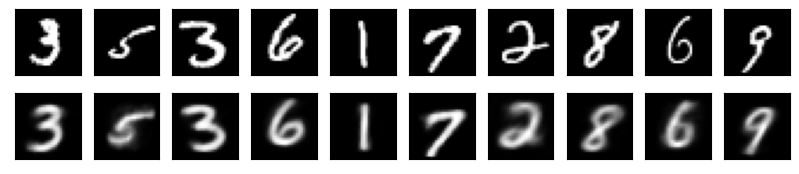

18 / 20
loss: 0.046851  [    0/60000]
loss: 0.039188  [ 6400/60000]
loss: 0.044828  [12800/60000]
loss: 0.043742  [19200/60000]
loss: 0.042477  [25600/60000]
loss: 0.070593  [32000/60000]
loss: 0.044233  [38400/60000]
loss: 0.038345  [44800/60000]
loss: 0.117516  [51200/60000]
loss: 0.076601  [57600/60000]
Test Error: 
 Accuracy: 77.0%, Avg loss: 9.022193 

[Epoch 18]


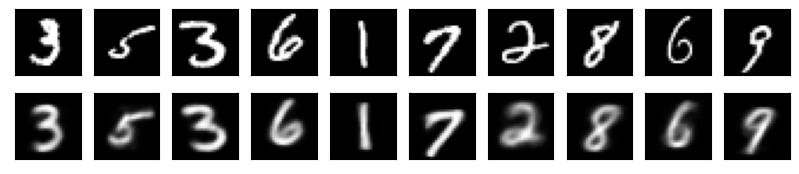

19 / 20
loss: 0.056258  [    0/60000]
loss: 0.048955  [ 6400/60000]
loss: 0.038126  [12800/60000]
loss: 0.049727  [19200/60000]
loss: 0.039008  [25600/60000]
loss: 0.040756  [32000/60000]
loss: 0.037542  [38400/60000]
loss: 0.044933  [44800/60000]
loss: 0.037251  [51200/60000]
loss: 0.042213  [57600/60000]
Test Error: 
 Accuracy: 74.0%, Avg loss: 11.355535 

[Epoch 19]


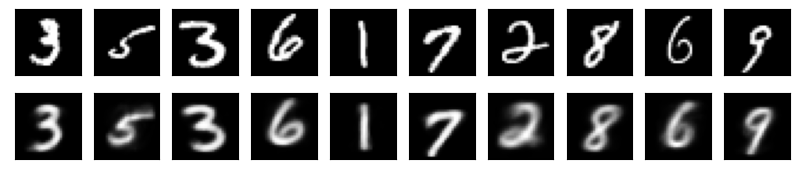

20 / 20
loss: 0.042293  [    0/60000]
loss: 0.038385  [ 6400/60000]
loss: 0.045280  [12800/60000]
loss: 0.041166  [19200/60000]
loss: 0.046402  [25600/60000]
loss: 0.035348  [32000/60000]
loss: 0.036591  [38400/60000]
loss: 0.045708  [44800/60000]
loss: 0.047185  [51200/60000]
loss: 0.035334  [57600/60000]
Test Error: 
 Accuracy: 74.2%, Avg loss: 11.238015 

[Epoch 20]


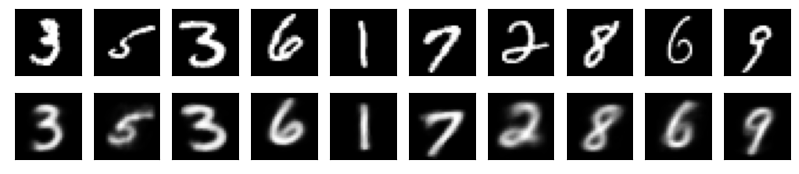

In [10]:
for epoch in range(1, EPOCH+1):
    print(epoch, "/" ,EPOCH)
    train(autoencoder, train_loader)
    test(autoencoder, test_loader, classify_criterion)
    
    test_x = view_data.to(DEVICE)
    _, decoded_data, _ = autoencoder(test_x)
    
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [ ]:
# encoder = autoencoder.encoder
# encoder.eval() # switch the encoder to evaluation mode

In [ ]:
def classify_train(classifier, train_loader, loss_fn):
    classifier.train()
    size = len(train_loader.dataset)
    
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        mean, std, var = torch.mean(x), torch.std(x), torch.var(x)
        x  = (x-mean)/std
        
        result = classifier(x)
        
#         loss = classify_criterion(result, label)
        loss = loss_fn(result, label)
        
        if step == 1:
            loss_history.append(loss.data)
        
        classify_optimizer.zero_grad()
        loss.backward()
        classify_optimizer.step()

        if step % 100 == 0:
            loss, current = loss.item(), step * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")